<a href="https://colab.research.google.com/github/Gaurav37/Reinforcement-Learning-Project-Practice/blob/master/notebook_monte_carlo_Gaurav_Singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE:  If you get error messages like `IOPub message rate exceeded.` while running this notebook, close your Jupyter instance and restart it adding the option `--NotebookApp.iopub_data_rate_limit=1.0e10`.  (As instructed [here](https://stackoverflow.com/a/44679222)).  Also try `--NotebookApp.iopub_msg_rate_limit=1.0e10`.

# Homework 3: Monte Carlo

In this assignment you will implement on-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. You will apply both of these algorithms on the frozen lake and blackjack environments and visualize their performance.

In [ ]:
import copy
import itertools as itt
from collections import defaultdict
from queue import deque

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

### Setup the Environment

This assignment uses two OpenAI gym environments: the frozen lake environment and the blackjack environment. Frozen lake is a grid world where the agent must reach a goal state while avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/), and the full description of blackjack [here](https://gym.openai.com/envs/Blackjack-v0/).  The blackjack implementation is the same as described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html).

In [ ]:
env_blackjack = BlackjackEnv()
env_frozen_lake = FrozenLakeEnv(desc=None, map_name="4x4", is_slippery=False)

### Exercise 1 (5 pts):

Implement e-greedy action selection based on the current Q-values. Break ties between equal Q-values randomly. Remember an action should be a number in the range: [0, num_actions - 1].

In [ ]:
def select_action_epsilon_greedy(Q_array, *, eps):
    """Perform epsilon greedy action selection based on the Q-values.
    
    Args:
        Q_array: A numpy array that contains Q-values relative to a single state.
        eps: The probability to select a random action. Float between 0 and 1.
    
    Returns:
        The selected action as an integer.
        
    Shapes:
        Q_array: `(A,)` where `A` is the number of actions.
        output: Scalar.
    """
    assert Q_array.ndim == 1
    
    #  YOUR CODE HERE:  select an action using the epsilon-greedy strategy, split ties randomly.
    
    """    #action = np.argmax(Q_array)
    if np.random.random()>eps : 
        QmaxInd = np.argwhere(Q_array == np.amax(Q_array))
        QmaxInd = QmaxInd.reshape((1, len(QmaxInd)))
        action = np.random.choice(QmaxInd[0])
    else:
        action = np.random.choice(np.arange(len(Q_array)))
    return action
    """
    
    probE=np.random.random()
    if eps<probE:
        #print("PROBE",probE)
        Qmax= np.max(Q_array)
        #print("QMAX",Qmax)
        Qmaxpos=np.where(Q_array==Qmax)
        #print("POS", Qmaxpos[0])
        #print("NEWPOS", Qmaxpos)
        #pos=pos.reshape(1,len(Qmaxpos[0]))
        action=np.random.choice(Qmaxpos[0])
    else :
        action=np.random.choice(len(Q_array))
    return action

Implement a procedure which samples and returns a trajectory from the environment, using the epsilon-greedy agent.  The trajectory is represented by a list of (state, action, reward) tuples.

In [ ]:
def sample_episode(env, Q, *, eps):
    """Sample an episode from the environment, using an epsilon-greedy policy based on Q.
    
    Args:
        env: The environment from which to sample episodes.
        Q: A dictionary mapping state -> action values array.
        eps: The epsilon-greedy parameter.
    
    Returns:
        transitions: A list of (state, action, reward) tuples describing the episode.
        
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
    """
    transitions = []  # store (state, action, reward) tuples here

    # YOUR CODE HERE:  sample an episode and store it in the transitions list.
    # NOTE: the Gym interface will require you to use the following methods
    # state = env.reset()  # initialize environment and get initial state
    # state_next, reward, done, info = env.step(action)  # perform action and receive next state, reward, done flag, and additional information.
    
    # ADVICE:  have a close look at what the state is (types and values), for both problems.
    state = env.reset()
    while True:
#         print(current_state)
        Qs = Q[state]
        choosen_action = select_action_epsilon_greedy(Q_array = Qs, eps = eps)
        next_state, reward, done, info = env.step(choosen_action)
        transitions.append( (state, choosen_action, reward) )
        state = next_state
        if done==True:
            break
    return transitions


### Exercise 2 (10 pts):

Implement the on-policy every-visit Monte Carlo update using the incremental update formula in Section 2.3 in SB. Recall that in Chapter 2 we averaged the *rewards* whereas in MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{equation}
    Q_{n+1} = Q_n + \alpha_n [G_n - Q_n]
\end{equation}
$$

In [ ]:
def on_policy_every_visit_mc_control(env, num_episodes, *, eps, gamma):
    """Train an on-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0.0 and 1.0.     
        gamma: The discount factor.
        
    Returns:
        Q: a dictionary mapping state -> action values array.
        returns: an array containing the returns obtained for each episode during training.
    
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
        returns: `(E,)` where E is the number of episodes we are using to train the agent.
    """
    
    # NOTE:  The pseudo-code in the book explicitly stores lists of returns for each (s,a) pair.
    # We want to be more memory-efficient;  so we will store counts `C` for each (s,a) pair, and use
    # the update rule in SB 2.3 to compute the same average, without having to store all the returns.

    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))

    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)  # progress bar
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode, and use the transition list to compute returns and update Q and C.

        trans=sample_episode(env, Q, eps=eps)
        
        trans.reverse()
        for count1 in trans:
            #print("COUNT1 VALUE",count1)
            #print("COUNT2",count1[0][1])
            G=G+count1[2]
            #print("GGGG is",G)
            C[count1[0]][count1[1]]+=1
            #Cbar=C[count1[0]][count1[1]]
            #print("CBAR",Cbar)
            Q[count1[0]][count1[1]]=Q[count1[0]][count1[1]]+((G-Q[count1[0]][count1[1]])/(C[count1[0]][count1[1]]))
        returns[i]=G
            #print("RETURNS",returns)
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
        
    return Q, returns
            #print("QNAME",Q)
        #print("LEN_OF_Q",len(Q))
        #for count in range(len(Q)):
#        """trans=sample_episode(env, Q, eps)
#        print("TRANS",trans)
#        #print("RANGE OF TRANS",range(trans))
#        #for count1 in reversed((trans)):
#        trans.reverse()
#        for count1 in trans:
#            #print("COUNT1 VALUE",count1)
#            #print("COUNT2",count1[0][1])
#            G=(gamma*G)+count1[0][2]
#            #print("GGGG is",G)
#            C[count1[0][0]][count1[0][1]]+=1
#            Cbar=C[count1[0][0]][count1[0][1]]
#            #print("CBAR",Cbar)
#            Q[count1[0][0]][count1[0][1]]=Q[count1[0][0]][count1[0][1]]+((G-Q[count1[0][0]][count1[0][1]])/Cbar)
#            returns=G
#            print("RETURNS",returns)
#            # diagnostics
#        G_queue.append(G)
#        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
#        """

### Exercise 3 (15 pts):

a) (2 pts) Calculate the learning curve (or returns) for the frozen lake environment, averaged over 50 independent runs and 1k episodes each, using $\gamma = 1.0$ and $\epsilon = 0.5$.

In [ ]:
num_runs, num_episodes = 50, 1_000
returns_fl = np.empty((num_runs, num_episodes))

print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")
print("#############################################################")

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    Q, returns = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, eps=0.015, gamma=1)
    returns_fl[i] = returns

#############################################################
#############################################################
#############################################################
#############################################################
#############################################################
#############################################################
#############################################################
#############################################################
#############################################################
#############################################################


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


b) (3 pts) Plot the resulting learning curve, averaging over the 50 runs, for the frozen lake environment.  If the results are noisy, use the following function to also plot, in the same figure, a smoother version of the same data.  Use these plots as a basis to find a better $\epsilon$ parameter, which makes the performance converge better.

In [ ]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.
    
    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window
        
    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

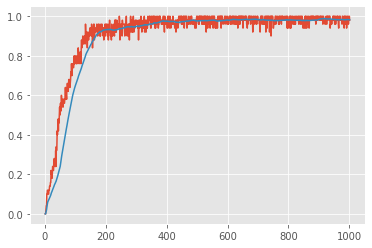

In [ ]:
# YOUR CODE HERE
average_of_returns = np.mean(returns_fl, axis = 0)
epi=(np.linspace(1,1001,1000))
plt.plot(epi,average_of_returns)
plt.plot(epi,rolling_average(average_of_returns, window_size=50))

c) (5 pts) Compute and plot the learning curve for the blackjack environment, this time averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.

In [ ]:
num_runs, num_episodes = 50, 5_000
returns_bj = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    Q, returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=0.02, gamma=1)
    returns_bj[i] = returns

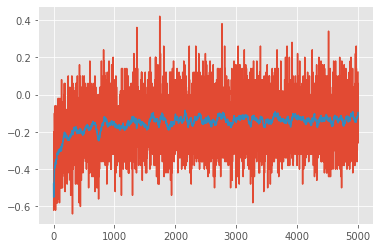

In [ ]:
# YOUR CODE HERE# YOUR CODE HERE
average_of_returns = np.mean(returns_bj, axis = 0)
epi=(np.linspace(1,5001,5000))
plt.plot(epi,average_of_returns)
plt.plot(epi,rolling_average(average_of_returns, window_size=50))


d) (2 pts) In both environments, the learning curve can be relatively noisy, even after we have supposedly converged to the semi-optimal policy.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why is it possible that the learning curve does not converge to a fixed value even if the policy itself has converged?

**YOUR ANSWER HERE**
The convergence is also dependent upon the number of episodes and gamma options. The graph becomes uniform or more fluctuated depending upon gamma as we saw earlier. Also Monte Carlo does not bootstrap which can also be a reason to take a longer time to converge because here the policy convergence is not directly linked with learning convergence.

e) (3 pts) You may have noticed that, sometimes, the second half of a run is relatively faster than the first half.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why does this make sense?  For which types of domains does this make sense?  Can the opposite also make sense (i.e. that the second half of a run runs slower than the first run)?  For which types of domains does this make sense?

While running these programs I did not notice any patterns in execution speed changes. However, the phenomenon can arise because the system has not learned or explored in the starting so initially it takes random actions and selects optimal actions from the pool of state action reward information it has gathered till now. So over time it makes use of that learning and takes less time.
I also noticed that program takes a longer time to run if epsilon values are larger because the emphasis on random action is more which over time may diminish system's performance So if epsilon values are large there is a possibility that the system may perform bad/less efficient in latter part when the need of exploration becomes less. in other words the system does not employ the learning/information it has gathered about optimal actions.

### Exercise 4 (10 pts):

Run your code up to 500k episodes for the blackjack domain with a step size parameter that enables the value function to converge. Plot the value function as a color plot with a similar layout to that shown in SB Figure 5.2.  If convenient, use the given `plot_surface` function, creates a 3D plot given matrices X and Y representing the 2D function domain, and matrix Z representing the function value at those domain inputs.

In [ ]:
def plot_surface(X, Y, Z, title):
    """Plot a 3d surface.

    Args:
        X: 2-d numpy.array indicating X positions (first input to the 3-d curve).
        Y: 2-d numpy.array indicating Y positions (second input to the 3-d curve).
        Z: 2-d numpy.array indicating Z positions (value of the 3-d curve).
        title: title of the plot
    """
    fig = plt.figure(figsize=(20, 10))
    ax = Axes3D(fig)
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        vmin=-1.0,
        vmax=1.0,
    )
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()


#YOUR CODE HERE
    
def on_policy_every_visit_mc_alpha_control(env, num_episodes, eps, alpha):
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    #C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))

    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)  # progress bar
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode, and use the transition list to compute returns and update Q and C.

        trans=sample_episode(env, Q, eps=eps)
        
        trans.reverse()
        for count1 in trans:
            #print("COUNT1 VALUE",count1)
            #print("COUNT2",count1[0][1])
            G=G+count1[2]
            #print("GGGG is",G)
            #C[count1[0]][count1[1]]+=1
            #Cbar=C[count1[0]][count1[1]]
            #print("CBAR",Cbar)
            Q[count1[0]][count1[1]]=Q[count1[0]][count1[1]]+(alpha*(G-Q[count1[0]][count1[1]]))#/(C[count1[0]][count1[1]]))
        returns[i]=G
            #print("RETURNS",returns)
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
        
    return Q, returns

In [ ]:
num_episodes = 500_000
# YOUR CODE HERE
num_runs=50
returns_bj = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    Q, returns = on_policy_every_visit_mc_alpha_control(env_blackjack, num_episodes, eps=0.4, alpha=1)
    returns_bj[i] = returns
Q, returns = on_policy_every_visit_mc_alpha_control(env_blackjack, 500000, eps=0.04, alpha=0.05)    

In [ ]:
def value_function(Qpi,eps):
    #Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    V = defaultdict(lambda: 0)
    #V2= defaultdict(lambda: 0)

    print("Vstarting",V)
    
    for a in Qpi:
        maxV=np.amax(Q[a])
        Vtotal= np.sum(Q[a]*eps/2) + (1-eps)*maxV
        if a[2]:
            V[a[0],a[1]]=Vtotal
        #else:
         #   V2[a[0],a[1]]
    print("V ending", V)
    return V
    

    



Vstarting defaultdict(<function value_function.<locals>.<lambda> at 0x000001980A8DD1E0>, {})
V ending defaultdict(<function value_function.<locals>.<lambda> at 0x000001980A8DD1E0>, {(14, 5): 0.006463624999999994, (19, 5): 0.052571109062499996, (21, 10): 0.8048880310268126, (16, 3): -0.097545125, (13, 4): 0.12759468125, (19, 10): -0.01679760602952631, (20, 10): 0.3198199695481788, (17, 2): -0.043767625000000004, (16, 4): -0.095288875, (20, 4): 0.1787883346875, (21, 4): 0.6159191678518706, (18, 10): -0.10853549085766104, (20, 7): 0.0417225, (17, 7): 0.000500000000000002, (21, 9): 0.5477660929109459, (16, 6): -0.0975043996875, (21, 8): -0.0009691631174737761, (17, 8): -0.211708831078125, (21, 5): 0.5842998256372278, (15, 5): 0.0012693812500000022, (14, 6): 0.06428022733671873, (16, 1): -0.0500475, (18, 7): 0.08747906954687501, (18, 9): 0.08236469718749999, (17, 4): 0.038561375, (18, 4): -0.005708625000000004, (21, 7): 0.7286139557486552, (21, 2): 0.5172157635881056, (21, 1): 0.30911008130

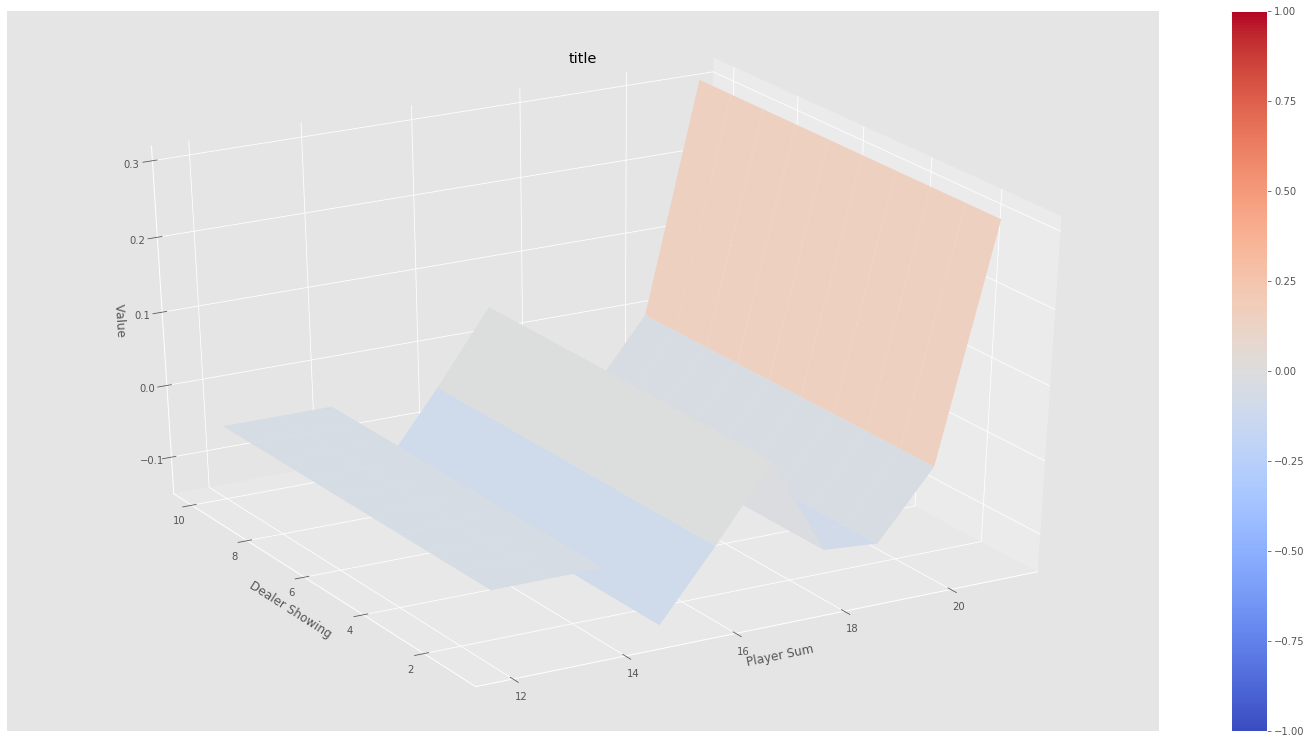

In [ ]:
#player = np.linspace(12, 23,1)
#dealer = np.linspace(1, 12,1)
player = np.arange(12, 22)
dealer = np.arange(1, 11)
Vz=value_function(Q,0.04)
#z=np.array(z)
x, y = np.meshgrid(player, dealer)
print("XXXX,YYYY", x , y)
fn = []
for why in y[0]:
    t = []
    for axe in x[0]:
        t.append( Vz[(axe, why)]) 
        
    fn.append(t)

fn = np.array(fn)
print(fn)
plot_surface(x, y, fn, "title")


### Exercise 5 (10 pts):

Implement the below function to train an off-policy every-visit MC agent which uses weighted importance sampling. As before, the behavior policy should be the epsilon greedy action selection.

In [ ]:
V = defaultdict(lambda: np.zeros())
print(V)

defaultdict(<function <lambda> at 0x000001980AAD41E0>, {})


In [ ]:
def off_policy_every_visit_weighted_control(env, num_episodes, *, eps, gamma):
    '''
    Trains an off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes for which to train the agent.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        
    Returns:
        Q is a dictionary mapping state -> action values array.
        returns is a list containing the rewards obtained for each episode during training.
    '''
    
    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))
    policy = defaultdict(int)
    
    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        G = 0.0
        W=1
        
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        trans=sample_episode(env, Q, eps=eps)
        
        trans.reverse()
        for count1 in trans:
            #print("COUNT1 VALUE",count1)
            #print("COUNT2",count1[0][1])
            G=(G*gamma)+count1[2]
            #print("GGGG is",G)
            C[count1[0]][count1[1]]=C[count1[0]][count1[1]]+W
            #Cbar=C[count1[0]][count1[1]]
            #print("CBAR",Cbar)
            Q[count1[0]][count1[1]]=Q[count1[0]][count1[1]]+((G-Q[count1[0]][count1[1]])*(W/C[count1[0]][count1[1]]))
            
            #pi(St)<-argmax(action where Q(St,a) value is max)
            
            #if action selected is not equal to policy action then break
            
            #W=W/b(At|St):::b is policy/probability as policy is based upon probability
                        
            #print("PROBE",probE)
            Qmax2= np.max(Q[count1[0]])
                #print("QMAX",Qmax)
            Qmaxpos2=np.where(Q[count1[0]]==Qmax2)
        #print("POS", Qmaxpos[0])
        #print("NEWPOS", Qmaxpos)
        #pos=pos.reshape(1,len(Qmaxpos[0]))
            action2=np.random.choice(Qmaxpos2[0])
            policy[count1[0]]= action2 #pi(state)=best action
            if count1[1] != policy[count1[0]]:
                break
            #else if count1[1] == policy[count1[0]]:
            if count1[1] == policy[count1[0]]:
                probE2= 1-eps+(eps/2)
            else:
                probE2=eps/2.0
            #    action=np.random.choice(len(Q_array))
            W=W/probE2
            
        returns[i]=G
            #print("RETURNS",returns)
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
        
    return Q, returns

### Exercise 6 (20 pts):

a) (5pts) Compute and plot the learning curve weighted importance sampling in the blackjack environment, averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.  Compare the results to those shown in exercise (3c).

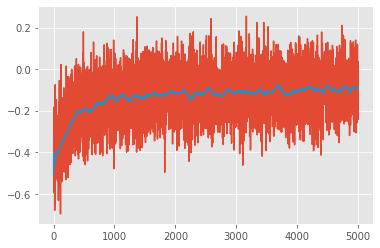

In [ ]:
num_runs, num_episodes = 50, 5_000

#returns_mc = np.empty((num_runs, num_episodes))
#for i in tqdm.tnrange(num_runs, desc='Runs (MC)'):
    # YOUR CODE HERE
    
returns_is = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    Q, returns=off_policy_every_visit_weighted_control(env_blackjack,num_episodes, eps=0.03,gamma=0.12)
    returns_is[i]=returns
    
avg_return=returns_is.sum(axis=0)/float(num_runs)
plt.plot(np.arange(1,5001),avg_return)
plt.plot(np.arange(1,5001), rolling_average(avg_return, window_size=100))

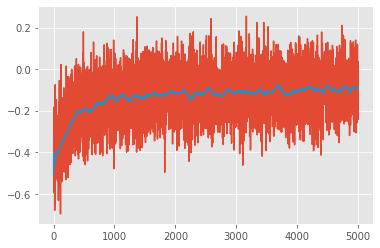

In [ ]:
# YOUR CODE HERE
avg_return=returns_is.sum(axis=0)/float(num_runs)
plt.plot(np.arange(1,5001),avg_return)
plt.plot(np.arange(1,5001), rolling_average(avg_return, window_size=100))

In [ ]:
# @ eps0.5 gamma 1 bad then earlier
#@ eps=0.03,gamma=0.12 much better

b) (5 pts) Now implement Monte Carlo Evaluation for the greddy policy of a Q function.

In [ ]:
def on_policy_mc_evaluation(env, Q, num_episodes, *, gamma):
    '''
    Monte Carlo policy Evaluation.
    
    Args:
        env: The environment to train the agent on.
        Q is a dictionary mapping state -> action values array.
        num_episodes: The number of episodes for which to evaluate the agent.
        gamma: The discount factor.
        
    Returns:
        returns is a list containing the rewards obtained for each episode.
    '''
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        G=0
        trans=sample_episode(env,Q,eps=0)
        trans.reverse()
        for count2 in trans:
            G=(gamma*G)+count2[2]  #On policy
        returns[i]=G    
        pbar.set_description(f'Episodes G={G}')
    #FOR ON POLICY GREEDY        
    return returns

c) (5 pts) Now run off-policy every-visit Importance Sampling control for 50 runs and 10k episodes, with $\epsilon = 0.1$, and plot the returns as you did previously.  Then, evaluate the Q function obtained by one of the 50 runs using the on-policy evaluation function, and print the resulting returns' mean and standard deviation.

In [ ]:
num_runs, num_episodes = 50, 10_000
#for off policy
returns_is = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    Q_,returns = off_policy_every_visit_weighted_control(env_blackjack, num_episodes, eps=0.1, gamma=0.12)
    returns_is[i] = returns
# YOUR CODE HERE
returns_on=on_policy_mc_evaluation(env_blackjack,Q_,num_episodes, gamma=1)

#print(returns_mc)
#returns_on=returns    


[-0.36 -0.52 -0.18 ... -0.12 -0.16  0.06]


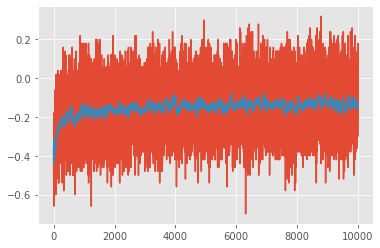

In [ ]:
avg_returns_off=returns_is.sum(axis=0)/float(num_runs)
print(avg_returns_off)
#seq1=np.linspace(1,num_episodes+1,1)
seq1=np.arange(1,num_episodes+1)
seq2=rolling_average(avg_returns_off,window_size=50)

plt.plot(seq1, avg_returns_off)
plt.plot(seq1, seq2)

avg_returns_on=returns_on.sum(axis=0)/float(num_runs)


In [ ]:
#FOR WEIGHTED
import statistics
mean_mc_weighted=np.mean(returns_is)
stand_dev_mc_weighted=np.std(returns_is)
print("MEAN",mean_mc_weighted)
print("STD_deviation",stand_dev_mc_weighted)

MEAN -0.151962
STD_deviation 0.951660417667983


In [ ]:
#FOR GREEDY ON POLICY

mean_mc_on=np.mean(returns_on)
stand_dev_mc_on=statistics.stdev(returns_on)
print("MEAN",mean_mc_on)
print("STD_deviation",stand_dev_mc_on)

MEAN -0.0774
STD_deviation 0.9536771938234666


d) **[graduate]** (5 pts) Do the mean and std match what is shown in the plot you got in exercise (7a)?  If not, explain why they are different.

**YOUR ANSWER HERE**